## Interpolación de valores faltantes

Primero cargamos la información y limpiamos los datos, así ocmo calcular las variables necesarias. 

In [19]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

ruta_guardado = r"C:\Users\mario\Desktop\MasterCienciadeDatos\TFM\TFM_MarioSoto\src\data_lake\PKL\dfs_final.pkl"

In [20]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [21]:
with open(ruta_guardado, 'rb') as f:
    dfs_final = pickle.load(f)

In [22]:
dfs = dfs_final

In [23]:
athletes_df = dfs['athletes_df']
athletes_events_df = dfs['athletes_events_df']
athletes_time_df = dfs['athletes_time_df']

issues_df = dfs['issues_df']
issues_events_df = dfs['issues_events_df']
issues_data_df = dfs['issues_data_df']
issues_times_df = dfs['issues_times_df']

In [24]:
athletes_time_df = dfs['athletes_time_df']

df = athletes_time_df.copy()

df['netTime_sec'] = df['netTime_td'].dt.total_seconds()

df = df.sort_values(['athlete_id', 'race_id', 'event_id', 'netTime_sec'])

df['prev_netTime'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['netTime_sec'].shift(1)
df['prev_split'] = df.groupby(['athlete_id', 'race_id', 'event_id'])['split'].shift(1)

df['first_split'] = df.groupby(['athlete_id', 'race_id', 'event_id']).cumcount() == 0
df['time_split_sec'] = 0.0
df.loc[df['split'] == 'Salida', 'time_split_sec'] = 0.0

mask_first = df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_first, 'time_split_sec'] = df.loc[mask_first, 'netTime_sec']

mask_rest = ~df['first_split'] & (df['split'] != 'Salida')
df.loc[mask_rest, 'time_split_sec'] = df.loc[mask_rest, 'netTime_sec'] - df.loc[mask_rest, 'prev_netTime']

athletes_time_df['time_split_sec'] = df['time_split_sec']
athletes_time_df['prev_split'] = df['prev_split']

negativos = df[df['time_split_sec'] < 0]
display(negativos[['athlete_id','race_id','event_id','prev_split','split','netTime_td','time_split_sec']])

,athlete_id,race_id,event_id,prev_split,split,netTime_td,time_split_sec


#### KNN clásico

Se usa para predecir una etiqueta o un valor de un dato nuevo.  
Se calcula la distancia entre el nuevo punto y los puntos del dataset.  
La predicción se hace por mayoría (clasificación) o promedio (regresión) de los k vecinos más cercanos.

**Fórmula regresión KNN:**

$\hat{y} = \frac{1}{k} \sum_{j \in N_i^k} y_j$

donde:

- $N_i^k$ son los k vecinos más cercanos al punto i en el dataset.

#### KNN Imputer (para imputación de datos faltantes)

Se aplica sobre un dataset con **NaN**.  
Para cada valor faltante $(x_{im} = \text{NaN})$, busca los k vecinos más cercanos que tengan ese valor presente y calcula un promedio ponderado para rellenarlo.

**Fórmula KNN Imputer:**

$\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}$

donde:

- $N_i^k(j)$ son los índices de los **k vecinos más cercanos** al atleta \(i\) que tienen el valor del split \(j\) disponible.
- $w_{il} = \frac{1}{d(i,l) + \epsilon}$ pondera por la distancia entre atletas en los splits conocidos.
- $d(i,l)$ puede ser, por ejemplo, la **distancia euclidiana** entre los vectores de splits existentes.

#### Naturaleza del problema

Consideremos un dataset donde cada fila representa a un atleta en un evento, y las columnas representan los tiempos en distintos splits (5K, 10K, 15K, 20K, Meta).  

Formalmente, la matriz de datos es:

$$
X = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1m} \\
x_{21} & x_{22} & \dots & x_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nm}
\end{bmatrix}, \quad x_{ij} \in \mathbb{R} \cup \{\text{NaN}\}
$$

Algunas entradas $x_{ij}$ pueden ser **NaN** debido a que el atleta no completó un split, hubo error de registro, o no participó en un evento parcial.

#### Por qué usar KNN Imputer en lugar de KNN clásico

Mientras que el **KNN clásico** se utiliza para clasificación o regresión de nuevas observaciones completas, **KNN Imputer** está diseñado específicamente para manejar **valores faltantes (NaN)** dentro de un dataset existente.

En nuestro caso, queremos imputar splits faltantes de atletas en carreras, donde algunas filas tienen datos incompletos.  

##### KNN clásico

Para un nuevo punto i, la predicción de un valor y_i se hace promediando los k vecinos más cercanos:

**Limitación:** Este método requiere que la fila de entrada esté completa. No puede procesar filas con valores faltantes $(\text{NaN})$ sin eliminarlas o rellenarlas primero.


##### KNN Imputer

Para un valor faltante \(x_{ij} = \text{NaN}\), KNN Imputer calcula:

$
\hat{x}_{ij} = \frac{\sum_{l \in N_i^k(j)} w_{il} \, x_{lj}}{\sum_{l \in N_i^k(j)} w_{il}}
$

**Ventajas en este contexto:**

1. **Manejo directo de valores faltantes:** No requiere eliminar filas incompletas.
2. **Similitud entre atletas:** Imputa usando vecinos que ya completaron ese split, reflejando patrones reales de rendimiento.
3. **Flexible ante datos dispersos:** Puede imputar aunque cada atleta tenga diferentes splits disponibles.
4. **Escalabilidad y coherencia:** Tras estandarizar los splits (por ejemplo con `StandardScaler`), las imputaciones respetan la proporción relativa de los tiempos entre splits.


#### Limitaciones

- **No captura dependencia temporal explícita:** Solo considera similitud de splits existentes, no la dinámica de tiempo entre splits consecutivos. Métodos secuenciales como GRU o Transformers pueden modelar mejor la evolución.
- **Sensibilidad a outliers:** Atletas con splits atípicos pueden alterar la imputación.
- **Requiere suficientes vecinos:** Para atletas con muchos splits faltantes o poco representados, la imputación puede ser menos precisa.

### Función: pasos principales

1. **Filtrado de eventos válidos**
   - Se seleccionan solo eventos de tipo `'media'` o `'maraton'` donde no faltan splits (`splitsMissing == 0`) ni hay splits consecutivos faltantes (`maxConsecutiveSplitsMissing == 0`). En esta prueba no incluimos carreras fuera de maraton debido a su mayor variabilidad en tiempos. 

2. **Selección y limpieza de columnas**
   - Se conservan columnas relevantes: `athlete_id`, `event_id`, `event_std`, `race_id`, `time_split_sec`, `prev_split`, `distance`, `split`.
   - Se eliminan los splits de salida (`split != 'Salida'`) y filas con `time_split_sec` faltante.

3. **Filtrado opcional por carrera**
   - Si se especifica `race_id_filter`, se filtran solo los datos de esa carrera.

4. **Transformación a formato ancho**
   - Cada fila representa un atleta en un evento/carrera.
   - Las columnas corresponden a los splits (`5K`, `10K`, `15K`, `20K`, `Meta`) y los valores son `time_split_sec`.

5. **Estandarización de splits**

6. **Introducción de NaN artificiales**

7. **Imputación con KNN Imputer**
   - Se usa `KNNImputer` con vecinos ponderados por distancia (`weights='distance'`) para rellenar los valores faltantes en los splits.

8. **Cálculo de errores**
    - Se compara el valor real vs imputado en escala estandarizada.
    - Se calcula el error absoluto promedio (`mae_scaled`).


In [51]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def imputacion_knn_maraton(athletes_events_df, athletes_time_df, nan_fraction=0.05, race_id_filter=None):

    # Filtrado de eventos válidos
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(['media', 'maraton']))
    ]
    events_subset = filtered_events[['athlete_id', 'event_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]
    
    # Merge con tiempos de splits
    merged_df = athletes_time_df.merge(events_subset, on=['athlete_id', 'event_id'], how='inner')
    
    # Selección y limpieza de columnas
    cols_to_keep = ['athlete_id', 'event_id', 'event_std', 'race_id', 'time_split_sec', 'prev_split', 'distance', 'split']
    df_subset = merged_df[cols_to_keep]
    df_subset = df_subset[df_subset['split'] != 'Salida'].copy()
    df_subset = df_subset.dropna(subset=['time_split_sec'])
    
    # Filtrado opcional por carrera
    if race_id_filter is not None:
        df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
        logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_subset)}")
    
    # Pivot a formato ancho
    df_wide = df_subset.pivot(index=['athlete_id', 'race_id', 'event_id'], columns='split', values='time_split_sec')
    logging.info(f"df_wide shape: {df_wide.shape}, filas con NaN: {df_wide.isna().any(axis=1).sum()}")
    
    # Estandarización de splits
    splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']
    scaler_filtered = StandardScaler()
    df_scaled_filtered = pd.DataFrame(
        scaler_filtered.fit_transform(df_wide[splits_to_keep]),
        index=df_wide.index,
        columns=splits_to_keep
    )
    
    df_wide_filtered = df_scaled_filtered.dropna().copy()
    df_wide_filtered_1 = df_wide_filtered.copy()

    print("df_wide_filtered_1.head():")
    print(df_wide_filtered_1.head())
    
    # Introducir NaN artificiales
    n_missing = int(nan_fraction * len(df_wide_filtered))
    rows_to_nan = np.random.choice(df_wide_filtered.index, size=n_missing, replace=False)
    for row in rows_to_nan:
        available_cols = df_wide_filtered.loc[row].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            df_wide_filtered.loc[row, col_to_nan] = np.nan
    
    # Imputación KNN
    imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_wide_filtered),
        index=df_wide_filtered.index,
        columns=df_wide_filtered.columns
    )
    
    # Comparación en escala estandarizada
    mask_stack_scaled = df_wide_filtered.isna().stack() & df_wide_filtered_1.stack().notna()
    original_values_only_scaled = df_wide_filtered_1.stack()[mask_stack_scaled]
    imputed_values_only_scaled = df_imputed.stack()[mask_stack_scaled]
    
    comparison_scaled = pd.DataFrame({
        'valor_real_scaled': original_values_only_scaled,
        'valor_imputado_scaled': imputed_values_only_scaled
    })
    comparison_scaled['abs_error_scaled'] = (comparison_scaled['valor_imputado_scaled'] - comparison_scaled['valor_real_scaled']).abs()
    mae_scaled = comparison_scaled['abs_error_scaled'].mean()
    
    # -------------------
    # GRÁFICO EN ESCALA
    plt.figure(figsize=(6, 6))
    plt.scatter(
        comparison_scaled["valor_real_scaled"],
        comparison_scaled["valor_imputado_scaled"],
        alpha=0.5
    )
    plt.xlabel("Valor real (escalado)")
    plt.ylabel("Valor imputado (escalado)")
    plt.title("Comparación valores reales vs imputados (KNN) en escala")
    min_val = min(comparison_scaled["valor_real_scaled"].min(), comparison_scaled["valor_imputado_scaled"].min())
    max_val = max(comparison_scaled["valor_real_scaled"].max(), comparison_scaled["valor_imputado_scaled"].max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red")
    plt.grid()
    plt.tight_layout()
    plt.show()
    # -------------------

    # Transformación de vuelta a segundos para comparación
    df_imputed_seconds = pd.DataFrame(
        scaler_filtered.inverse_transform(df_imputed),
        index=df_imputed.index,
        columns=df_imputed.columns
    )
    df_original_seconds = pd.DataFrame(
        scaler_filtered.inverse_transform(df_wide_filtered_1),
        index=df_wide_filtered_1.index,
        columns=df_wide_filtered_1.columns
    )
    
    original_stack_sec = df_original_seconds.stack()
    imputed_stack_sec = df_imputed_seconds.stack()
    mask_stack_sec = df_wide_filtered.isna().stack() & original_stack_sec.notna()
    
    original_values_only_sec = original_stack_sec[mask_stack_sec]
    imputed_values_only_sec = imputed_stack_sec[mask_stack_sec]
    
    comparison_sec = pd.DataFrame({
        'split': original_values_only_sec.index.get_level_values(3),
        'valor_real_sec': original_values_only_sec.values,
        'valor_imputado_sec': imputed_values_only_sec.values
    })
    comparison_sec['abs_error_sec'] = (comparison_sec['valor_imputado_sec'] - comparison_sec['valor_real_sec']).abs()
    
    mae_seconds = comparison_sec['abs_error_sec'].mean()
    
    # -------------------
    # GRÁFICO EN SEGUNDOS
    plt.figure(figsize=(6, 6))
    plt.scatter(
        comparison_sec["valor_real_sec"] / 60,
        comparison_sec["valor_imputado_sec"] / 60,
        alpha=0.5
    )
    plt.xlabel("Valor real (minutos)")
    plt.ylabel("Valor imputado (minutos)")
    plt.title("Comparación valores reales vs imputados (KNN) en segundos")
    max_val_min = max(comparison_sec["valor_real_sec"].max(), comparison_sec["valor_imputado_sec"].max()) / 60
    plt.plot([0, max_val_min], [0, max_val_min], linestyle="--", color="red")
    plt.grid()
    plt.tight_layout()
    plt.show()
    # -------------------

    # Ejemplos por split
    def sec_to_hhmmss(x):
        return pd.to_timedelta(x, unit="s")

    ejemplos_por_split = {}
    for split in ['5K', '10K', '15K', '20K', 'Meta']:
        df_split = comparison_sec[comparison_sec['split'] == split].copy()
        if len(df_split) >= 5:
            df_sample = df_split.sample(5, random_state=42)
        else:
            df_sample = df_split.copy()
        df_sample['real_hhmmss'] = df_sample['valor_real_sec'].apply(sec_to_hhmmss)
        df_sample['imputado_hhmmss'] = df_sample['valor_imputado_sec'].apply(sec_to_hhmmss)
        ejemplos_por_split[split] = df_sample[['valor_real_sec', 'valor_imputado_sec', 'real_hhmmss', 'imputado_hhmmss']].reset_index(drop=True)

    mae_per_split = {
        split: comparison_sec.loc[comparison_sec['split']==split, 'abs_error_sec'].mean()
        for split in ['5K', '10K', '15K', '20K', 'Meta']
    }

    print("MAE por split calculado:", mae_per_split)

    return mae_scaled, mae_seconds, ejemplos_por_split, mae_per_split

INFO: Filtrado por race_id=4675cb02-b97a-424b-a40f-49a961e02f58, filas restantes: 210321
INFO: df_wide shape: (21387, 10), filas con NaN: 721


df_wide_filtered_1.head():
                                                                                          5K  \
athlete_id                           race_id                              event_id             
01eca658-9206-509d-b977-10aa8c33dcb9 4675cb02-b97a-424b-a40f-49a961e02f58 Marato    1.540840   
042a4b4e-6e1c-5896-9173-b0fc7963d82c 4675cb02-b97a-424b-a40f-49a961e02f58 Marato   -0.119431   
04a810fd-4cd3-5521-9ebb-bb50c3897b6e 4675cb02-b97a-424b-a40f-49a961e02f58 Marato   -0.582202   
05b1654f-a583-5e81-a92b-78fa6637f114 4675cb02-b97a-424b-a40f-49a961e02f58 Marato   -2.367024   
09e75d6c-2301-4400-8ade-d0cc57233ae2 4675cb02-b97a-424b-a40f-49a961e02f58 Marato    1.694731   

                                                                                         10K  \
athlete_id                           race_id                              event_id             
01eca658-9206-509d-b977-10aa8c33dcb9 4675cb02-b97a-424b-a40f-49a961e02f58 Marato    2.280350   
042a4b4e-6e1

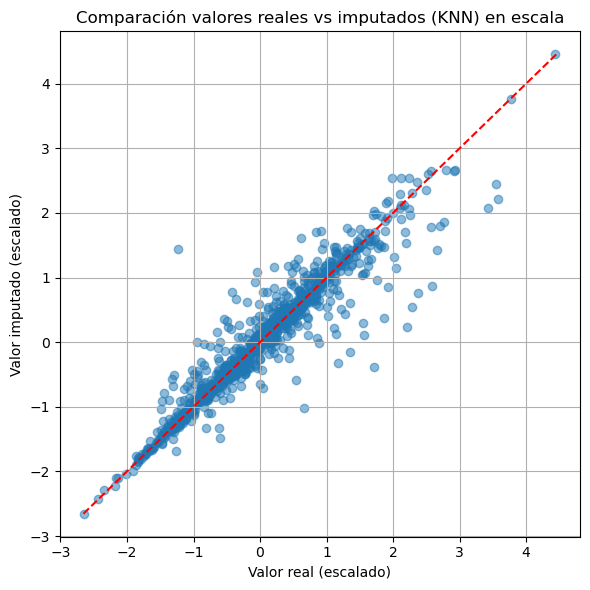

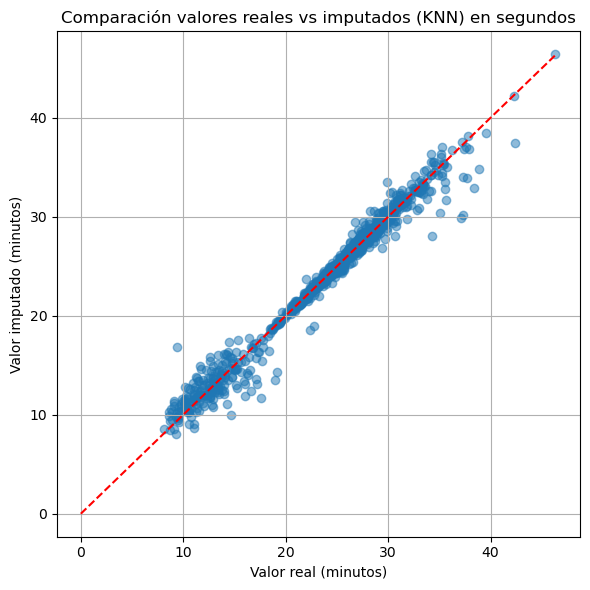

MAE por split calculado: {'5K': 25.499101742062553, '10K': 27.13078864103021, '15K': 22.25017463761864, '20K': 28.685580046598666, 'Meta': 74.89120420671892}


In [53]:
mae_scaled, mae_seconds, examples_min, mae_per_split = imputacion_knn_maraton(
    athletes_events_df, athletes_time_df, nan_fraction=0.05, race_id_filter='4675cb02-b97a-424b-a40f-49a961e02f58'
)

Vemos cómo en la parte inicial y final de la carrera se d¡suelen cometer más errores por la forma del gráfico

Podemos ver como en la gran mayoría de los splits hay una error cercano al medio minuto

### pruebas

In [54]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


def evaluar_knn(df_scaled, scaler, params, nan_fraction=0.05, random_state=42):
    df_original = df_scaled.copy()
    df_missing = df_scaled.copy()
    np.random.seed(random_state)

    n_rows = len(df_missing)
    n_nan_rows = max(1, int(nan_fraction * n_rows))
    rows_nan = np.random.choice(df_missing.index, size=n_nan_rows, replace=False)

    for row in rows_nan:
        col = np.random.choice(df_missing.columns)
        df_missing.loc[row, col] = np.nan

    imputer = KNNImputer(**params)
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_missing),
        index=df_missing.index,
        columns=df_missing.columns
    )

    df_original_sec = pd.DataFrame(
        scaler.inverse_transform(df_original),
        index=df_original.index,
        columns=df_original.columns
    )
    df_imputed_sec = pd.DataFrame(
        scaler.inverse_transform(df_imputed),
        index=df_imputed.index,
        columns=df_imputed.columns
    )

    mask_missing = df_missing.isna()
    dif = (df_original_sec[mask_missing] - df_imputed_sec[mask_missing]).abs()
    mae = dif.stack().mean()

    return mae


def plot_imputation_errors(df_original, df_imputed, mask_missing, title="Errores de imputación"):
    y_true = df_original[mask_missing].stack()
    y_pred = df_imputed[mask_missing].stack()
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Valor real (s)")
    plt.ylabel("Valor imputado (s)")
    plt.title(title)
    plt.grid(True)
    plt.show()


def imputacion_knn_maraton(athletes_events_df, athletes_time_df, athletes_df,
                           nan_fraction=0.05, race_id_filter=None,
                           event_std=["media", "maraton"]):

    
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(event_std))
    ][['athlete_id', 'event_id', 'race_id']]

    
    athletes_time_df['rawTime'] = pd.to_datetime(athletes_time_df['rawTime'])
    race_dates = athletes_time_df.groupby('race_id')['rawTime'].min().reset_index()
    race_dates.rename(columns={'rawTime': 'race_date'}, inplace=True)

    merged_df = athletes_time_df.merge(filtered_events, on=['athlete_id', 'event_id', 'race_id'], how='inner')
    merged_df = merged_df.merge(race_dates, on='race_id', how='left')

    athletes_df['birthdate'] = pd.to_datetime(athletes_df['birthdate'])
    merged_df = merged_df.merge(athletes_df[['athlete_id', 'birthdate']], on='athlete_id', how='left')

    merged_df['age_at_race'] = (merged_df['race_date'] - merged_df['birthdate']).dt.total_seconds() / (365.25*24*3600)

    
    cols_to_keep = ['athlete_id', 'event_id', 'race_id', 'split', 'time_split_sec', 'age_at_race']
    df_subset = merged_df[cols_to_keep]
    df_subset = df_subset[df_subset['split'] != 'Salida'].copy()
    df_subset = df_subset.dropna(subset=['time_split_sec'])

    if race_id_filter is not None:
        df_subset = df_subset[df_subset['race_id'] == race_id_filter].copy()
        logging.info(f"Filtrado por race_id={race_id_filter}, filas restantes: {len(df_subset)}")

    
    df_wide = df_subset.pivot(index=['athlete_id', 'race_id', 'event_id', 'age_at_race'],
                              columns='split', values='time_split_sec')
    
    splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']
    df_wide = df_wide[splits_to_keep]

    
    split_distances = {'5K': 5, '10K': 10, '15K': 15, '20K': 20, 'Meta': 42.195}
    df_velocity = df_wide.copy()
    for split in splits_to_keep:
        df_velocity[split + '_vel_kmh'] = split_distances[split] / (df_wide[split] / 3600)  # seg → horas

    vel_cols = [c for c in df_velocity.columns if '_vel_kmh' in c]
    df_velocity['split_consistency_std'] = df_velocity[vel_cols].std(axis=1)

    
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_wide),
                             index=df_wide.index, columns=df_wide.columns)
    df_scaled_clean = df_scaled.dropna().copy()


    param_grid = {"n_neighbors": [3,5,7,10,15], "weights": ["uniform","distance"], "metric": ["nan_euclidean"]}
    best_mae = float("inf")
    best_params = None
    for k in param_grid["n_neighbors"]:
        for w in param_grid["weights"]:
            for m in param_grid["metric"]:
                params = {"n_neighbors": k, "weights": w, "metric": m}
                mae = evaluar_knn(df_scaled_clean, scaler, params, nan_fraction=nan_fraction)
                if mae < best_mae:
                    best_mae = mae
                    best_params = params

    logging.info(f"Mejores parámetros KNN: {best_params}, MAE tuning: {best_mae:.2f} s")


    df_missing = df_scaled_clean.copy()
    np.random.seed(42)
    n_rows = len(df_missing)
    n_nan_rows = max(1, int(nan_fraction * n_rows))
    rows_nan = np.random.choice(df_missing.index, size=n_nan_rows, replace=False)
    for row in rows_nan:
        col = np.random.choice(df_missing.columns)
        df_missing.loc[row, col] = np.nan


    imputer = KNNImputer(**best_params)
    df_imputed = pd.DataFrame(imputer.fit_transform(df_missing),
                              index=df_missing.index, columns=df_missing.columns)


    df_original_sec = pd.DataFrame(scaler.inverse_transform(df_scaled_clean),
                                   index=df_scaled_clean.index, columns=df_scaled_clean.columns)
    df_imputed_sec = pd.DataFrame(scaler.inverse_transform(df_imputed),
                                  index=df_missing.index, columns=df_missing.columns)

    mask_missing = df_missing.isna()
    mae_seconds = (df_original_sec[mask_missing] - df_imputed_sec[mask_missing]).abs().stack().mean()

    mae_per_split = {}
    ejemplos_por_split = {}
    for split in df_missing.columns:
        mae_per_split[split] = (df_original_sec[split][mask_missing[split]] -
                                df_imputed_sec[split][mask_missing[split]]).abs().mean()
        df_split = pd.DataFrame({'athlete_id': df_missing.index,
                                 'abs_error': (df_original_sec[split] - df_imputed_sec[split]).abs()})
        df_split = df_split[mask_missing[split]]
        ejemplos_por_split[split] = df_split.sort_values('abs_error', ascending=False).head(5).reset_index(drop=True)


    plot_imputation_errors(df_original_sec, df_imputed_sec, mask_missing)

    return best_mae, mae_seconds, ejemplos_por_split, mae_per_split, best_params, df_velocity

INFO: Filtrado por race_id=2fa6d70a-afef-4f4e-880e-deea01248d9b, filas restantes: 131913
INFO: Mejores parámetros KNN: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'nan_euclidean'}, MAE tuning: 27.01 s


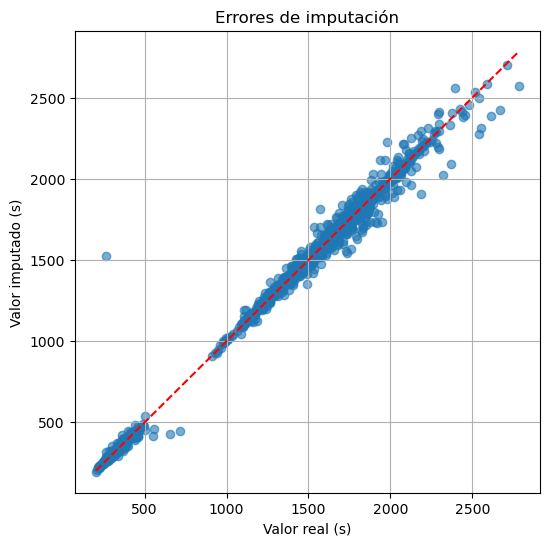

In [55]:
best_mae, mae_seconds, ejemplos_por_split, mae_per_split, best_params, df_velocity = imputacion_knn_maraton(athletes_events_df, athletes_time_df, athletes_df, nan_fraction=0.05, race_id_filter='2fa6d70a-afef-4f4e-880e-deea01248d9b', event_std=["media"])

### pruebas

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def imputacion_knn_maraton(
    athletes_events_df, 
    athletes_time_df, 
    nan_fraction=0.05, 
    race_id_filter=None,
    event_id_filter=None
):
    filtered_events = athletes_events_df[
        (athletes_events_df['splitsMissing'] == 0) &
        (athletes_events_df['maxConsecutiveSplitsMissing'] == 0) &
        (athletes_events_df['event_std'].isin(['media', 'maraton']))
    ]
    events_subset = filtered_events[['athlete_id', 'event_id', 'splitsMissing', 'maxConsecutiveSplitsMissing']]

    merged_df = athletes_time_df.merge(events_subset, on=['athlete_id', 'event_id'], how='inner')

    cols_to_keep = ['athlete_id', 'event_id', 'event_std', 'race_id', 
                    'time_split_sec', 'prev_split', 'distance', 'split']
    df_subset = merged_df[cols_to_keep]
    df_subset = df_subset[df_subset['split'] != 'Salida'].copy()
    df_subset = df_subset.dropna(subset=['time_split_sec'])

    if race_id_filter is not None and event_id_filter is not None:
        df_subset = df_subset[
            (df_subset['race_id'] == race_id_filter) &
            (df_subset['event_id'] == event_id_filter)
        ].copy()
        logging.info(f"Filtrado por race_id={race_id_filter} y event_id={event_id_filter}, filas restantes: {len(df_subset)}")
        splits_to_keep = df_subset['split'].unique().tolist()
        logging.info(f"Splits disponibles dinámicamente: {splits_to_keep}")
    else:
        splits_to_keep = ['5K', '10K', '15K', '20K', 'Meta']
        logging.info(f"No se filtra por carrera/evento, usando splits por defecto: {splits_to_keep}")

    df_wide = df_subset.pivot(index=['athlete_id', 'race_id', 'event_id'], 
                              columns='split', values='time_split_sec')
    logging.info(f"df_wide shape: {df_wide.shape}, filas con NaN: {df_wide.isna().any(axis=1).sum()}")
    df_wide_filtered_1 = df_wide.copy()

    scaler_filtered = StandardScaler()
    df_scaled_filtered = pd.DataFrame(
        scaler_filtered.fit_transform(df_wide[splits_to_keep]),
        index=df_wide.index,
        columns=splits_to_keep
    )
    df_wide_filtered = df_scaled_filtered.dropna().copy()

    n_missing = int(nan_fraction * len(df_wide_filtered))
    rows_to_nan = np.random.choice(df_wide_filtered.index, size=n_missing, replace=False)
    for row in rows_to_nan:
        available_cols = df_wide_filtered.loc[row].dropna().index
        if len(available_cols) > 0:
            col_to_nan = np.random.choice(available_cols, size=1)[0]
            df_wide_filtered.loc[row, col_to_nan] = np.nan

    imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_wide_filtered),
        index=df_wide_filtered.index,
        columns=df_wide_filtered.columns
    )


    df1_scaled = df_wide_filtered.copy()
    df2_scaled = df_wide_filtered_1[splits_to_keep].loc[df1_scaled.index] 

    mask_stack_scaled = df1_scaled.isna().stack() & df2_scaled.stack().notna()
    original_values_only_scaled = df2_scaled.stack()[mask_stack_scaled]
    imputed_values_only_scaled = df_imputed.stack()[mask_stack_scaled]

    comparison_scaled = pd.DataFrame({
        'valor_real_scaled': original_values_only_scaled,
        'valor_imputado_scaled': imputed_values_only_scaled
    })
    comparison_scaled['abs_error_scaled'] = (comparison_scaled['valor_imputado_scaled'] - comparison_scaled['valor_real_scaled']).abs()
    mae_scaled = comparison_scaled['abs_error_scaled'].mean()

    plt.figure(figsize=(6, 6))
    plt.scatter(comparison_scaled["valor_real_scaled"], comparison_scaled["valor_imputado_scaled"], alpha=0.5)
    plt.xlabel("Valor real (escalado)")
    plt.ylabel("Valor imputado (escalado)")
    plt.title("Comparación valores reales vs imputados (KNN) en escala")
    min_val = min(comparison_scaled["valor_real_scaled"].min(), comparison_scaled["valor_imputado_scaled"].min())
    max_val = max(comparison_scaled["valor_real_scaled"].max(), comparison_scaled["valor_imputado_scaled"].max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red")
    plt.grid()
    plt.tight_layout()
    plt.show()


    df_imputed_seconds = pd.DataFrame(
        scaler_filtered.inverse_transform(df_imputed),
        index=df_imputed.index,
        columns=df_imputed.columns
    )
    df_original_seconds = pd.DataFrame(
        scaler_filtered.inverse_transform(df_wide_filtered_1[splits_to_keep].loc[df_imputed.index]),
        index=df_imputed.index,
        columns=splits_to_keep
    )

    original_stack_sec = df_original_seconds.stack()
    imputed_stack_sec = df_imputed_seconds.stack()
    mask_stack_sec = df1_scaled.isna().stack() & original_stack_sec.notna()
    original_values_only_sec = original_stack_sec[mask_stack_sec]
    imputed_values_only_sec = imputed_stack_sec[mask_stack_sec]

    comparison_sec = pd.DataFrame({
        'split': original_values_only_sec.index.get_level_values(2),
        'valor_real_sec': original_values_only_sec.values,
        'valor_imputado_sec': imputed_values_only_sec.values
    })
    comparison_sec['abs_error_sec'] = (comparison_sec['valor_imputado_sec'] - comparison_sec['valor_real_sec']).abs()
    mae_seconds = comparison_sec['abs_error_sec'].mean()

    plt.figure(figsize=(6, 6))
    plt.scatter(comparison_sec["valor_real_sec"] / 60, comparison_sec["valor_imputado_sec"] / 60, alpha=0.5)
    plt.xlabel("Valor real (minutos)")
    plt.ylabel("Valor imputado (minutos)")
    plt.title("Comparación valores reales vs imputados (KNN) en segundos")
    max_val_min = max(comparison_sec["valor_real_sec"].max(), comparison_sec["valor_imputado_sec"].max()) / 60
    plt.plot([0, max_val_min], [0, max_val_min], linestyle="--", color="red")
    plt.grid()
    plt.tight_layout()
    plt.show()

    
    def sec_to_hhmmss(x):
        return pd.to_timedelta(x, unit="s")

    ejemplos_por_split = {}
    for split in splits_to_keep:
        df_split = comparison_sec[comparison_sec['split'] == split].copy()
        if len(df_split) >= 5:
            df_sample = df_split.sample(5, random_state=42)
        else:
            df_sample = df_split.copy()
        df_sample['real_hhmmss'] = df_sample['valor_real_sec'].apply(sec_to_hhmmss)
        df_sample['imputado_hhmmss'] = df_sample['valor_imputado_sec'].apply(sec_to_hhmmss)
        ejemplos_por_split[split] = df_sample[['valor_real_sec', 'valor_imputado_sec', 'real_hhmmss', 'imputado_hhmmss']].reset_index(drop=True)

    mae_per_split = {split: comparison_sec.loc[comparison_sec['split']==split, 'abs_error_sec'].mean() 
                     for split in splits_to_keep}

    print("MAE por split calculado:", mae_per_split)

    return mae_scaled, mae_seconds, ejemplos_por_split, mae_per_split